## Lab 5

### Modelo lineal probabilistico.

Manuel Felipe Pineda

#### Objetivo:
Implementar un modelo de decision lineal (probabilistico) basado en la clase 5. 


**NOTA:** Tener en cuenta que se deben tener suficientes datos de entrada para poder 
asumir una distribucion normal de los mismos.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sb
import pandas as pd
import scipy as sp

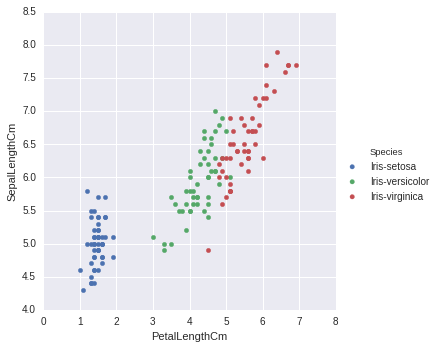

In [2]:
iris = pd.read_csv('lab4/iris/Iris.csv')

sb.FacetGrid(iris, hue="Species", size=5).map(plt.scatter, "PetalLengthCm", "SepalLengthCm").add_legend()

## Descripcion

Se usara uno de los datasets clasicos (plantas iris) para probar el modelo de **regresion logistica**. En este caso se busca diferenciar la especie **iris-setosa** de las otras 2.

In [3]:
def get_data():
    arr = np.array(iris["PetalLengthCm"].values, dtype = np.float64)
    columns = arr.shape[0]
    arr = np.append(arr, iris["SepalLengthCm"].values, axis=0)
    rows = arr.shape[0] // columns
    arr = arr.reshape(rows, columns)
    arr[0] = np.array(arr[0], dtype = np.float64)
    arr = arr.T
    N = arr.shape[0] // 3
    b = np.vstack((np.ones((N, 1)),  -1 * np.ones((2 * N, 1))))
    return arr, b

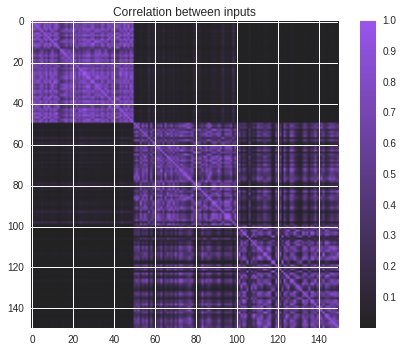

In [4]:
data, t = get_data()

def com_phi(data, sig = 0.5):
    X = sp.spatial.distance.pdist(data)
    X = sp.spatial.distance.squareform(X)
    sig = 0.5
    X = np.exp(-X / (2.0 * sig))
    return X

X = com_phi(data)
cmap = sb.dark_palette("#9955ee", as_cmap=True)
plt.imshow(X,cmap=cmap)
plt.colorbar()
plt.title('Correlation between inputs')
plt.show()

### Funcion de error y gradiente

#### Funcion de clasificacion:
Se usara un sigmoide logistico para determinar la clase de una muestra como funcion lineal de las caracteristicas

$$
    y(X) = \sigma (\mathbf{W^\top \phi})
$$
donde $\mathbf{\phi}$ es una transformacion no lineal de las caracteristicas (En este caso un kernel gaussiano)

#### Likelihood

$$
    p(\mathbf{t} \mid X ) = \prod_{n = 1}^{N} Y_n^{t_n}{1 - Y_n}^{1 - t_n}
$$

#### Funcion de error

Dado que queremos maximizar el likelihood, podemos escribir la funcion de error como:

\begin{align}
    E(w) &= -\log p(\mathbf{t} \mid X ) \\
    &= - \sum_{n = 1}^{N} \{t_n \log Y_n  + (1 - t_n) \log(1 - Y_n)\}
\end{align}


Del cual podemos obtener el gradiente con respecto a los pesos $w$ y asi optimizarlo

$$
    \nabla E(w) = \sum_{n = 1}^{N} (Y_n - t_n)\mathbf(\phi_n)
$$

In [31]:
def sigmoid(x):
    return min(max(1.0 / (1.0 - np.exp(-x)), 0), 1)

sigmoid = np.vectorize(sigmoid)

def error(X, t, w, eps = 1e-20):
    Y = sigmoid(X.dot(w))
    c1 = t == 1
    c2 = t == -1
    a = np.sum(np.log(Y[c1] + eps))
    b = np.sum(np.log(1.0 - Y[c2] + eps))
    return -(a + b)

def grad(X, t, w):
    Y = sigmoid(X.dot(w))
    return X.dot(Y - t)

def train(X, t, w_ini, alpha = 0.5, debug = None,
          steps = 1, max_iter = 100, tol = 1e-9):
    for it in range (max_iter):
        w = w_ini - alpha * grad(X, t, w_ini)
        
        if (debug and (it % steps == 0)):
            debug(X, t, w, w_ini, alpha, it)
            
        if (np.abs(np.sum(w - w_ini)) < tol or error(X, t, w) < tol):
            break
        w_ini = w
    return w_ini


def dbg(X, t, w, w_init, alpha, it):
    print ('Error on it %d : %f' % (it, error(X, t, w)))
    # print (sigmoid(X.dot(w)))

def count_miss(t, y, eps = 1e-15):
    c1  = np.abs(y - 1) < eps
    c2  = np.abs(y - 1) >= eps
    a = np.sum(t[c1] != 1)
    b = np.sum(t[c2] != -1)
    print('Missclasified after train %d, %d of class 1 and %d of class 2' % (a + b, a, b))
    
data, t = get_data()
X = com_phi(data, 0.1)
w = 7 * np.ones((X.shape[0], 1))
w_opt = train(X, t, w, 0.01, dbg, tol = 1e-15, steps = 2)
y_pred = sigmoid(X.dot(w_opt))
count_miss(t, y_pred)

Error on it 0 : 4605.170186
Error on it 2 : 4605.170186
Error on it 4 : 4605.170186
Error on it 6 : 4605.170186
Error on it 8 : 3269.670832
Error on it 10 : 690.775528
Error on it 12 : 184.206807
Error on it 14 : 138.155106
Error on it 16 : 92.103404
Error on it 18 : 46.051702
Error on it 20 : -0.000000
Missclasified after train 1, 1 of class 1 and 0 of class 2


### Conclusiones

- Se implemento el modelo de regresion logistica utilizando *gradiend descent*.
- La funcion *simoid*, presenta varios problemas de precision al momento de realizar los calculos en el computador, debido a esto es importante asegurarse que el valor de retorno esta entre 0 y 1.
- En la funcion de costo (negative log likelihood) tambien hay problemas de estabilidad numerica debido a que se toma el logaritmo de una probabilidad que puede tomar valores de 0, por lo que es importante agregar un valor de regularizacion. 